# Main



Now some text explaining stuff

## General requirements

In [1]:
from matplotlib.pylab import *
from numpy import *
%matplotlib inline

In [2]:
from Nanorods.sub.subs import *
from matlab.function_EMCCD_CMOS_calib import *

In [3]:
import PIL
import PIL.ExifTags as Exiftags

In [4]:
from matlab.tifmethods import readBigTifFile

In [6]:
windows = True
if windows:
    fname = "C:\\Users\ludwig\Documents\Python data\cell1_BeRST.tif"
else:
    fname = '/mnt/data/Anastasia/sample folder with NR data/image files/cell1_BeRST.tif'
movie = readBigTifFile(fname)
movie = movie.sum(axis=0)

(<Figure size 504x324 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x216467bc908>)

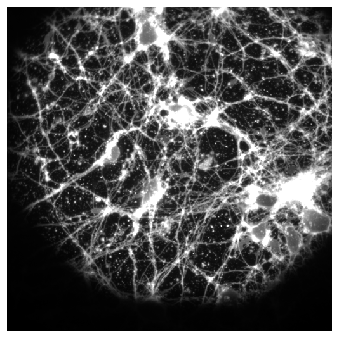

In [7]:
visualization(movie)

In [8]:
if windows:
    folder = r"C:\Users\ludwig\data\NR sample files\18_11_29_pd23_11_div6_WIS_NR-BeRST\image files"
    fname = r"\wave\cell1_1.tif"
    fwave = r"\wave\cell1_1.tif"
    fctrl = r"\control\cell1_2.tif"
    file_Berst='\cell1_BeRST.tif'
    foldercalib = "\EMCCD-CMOS calib\\"
else:
    folder = '/mnt/data/Anastasia/sample folder with NR data/image files/'
    fname = 'wave/cell1_1.tif'
    fwave = 'wave/cell1_1.tif'
    fctrl = 'control/cell1_2.tif'
    file_Berst='cell1_BeRST.tif'
    foldercalib = "EMCCD-CMOS calib/"


In [9]:
movie = readBigTifFile(folder+fname)
movie = movie.sum(axis=0) # sum(movie,axis=0)

(<Figure size 504x324 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2164668ab00>)

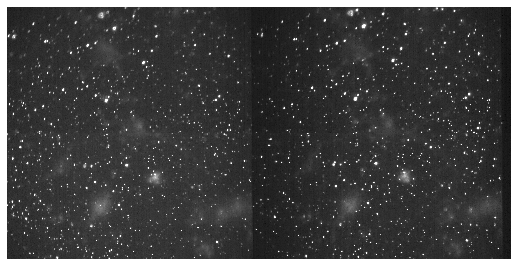

In [10]:
visualization(movie)

##     Mask generation and three fields alignment.

### cMOS camera fields alignment
### EMCCD mask generation
### Transposition of mask two CMOS images


In [11]:
from matlab.function_EMCCD_CMOS_calib import EMCCD_CMOS_calib

In [12]:
#file_wave='\cell1_BeRST.tif'
f=3 #averaging factor for the mask

#EMCCD-CMOS calib results
print(folder+foldercalib)
ax, ay, bx, by = EMCCD_CMOS_calib(folder+foldercalib)

C:\Users\ludwig\data\NR sample files\18_11_29_pd23_11_div6_WIS_NR-BeRST\image files\EMCCD-CMOS calib\


In [13]:
print(ax, ay,bx, by)

0.7910246816347403 0.8152787153028243 74.96592913252289 -33.87204042892071


In [14]:
from matlab.tifmethods import *
info = readtifInfo(folder+file_Berst)
NframesStr = [d for d in info[270].split('\n') if d.find('frames')>=0][0].split('=')[-1]
Nframes = int(NframesStr)
Stim=tile([-60, 0],Nframes//2);

movie = readBigTifFile(folder+file_Berst)
movie_sum = movie.sum(axis=0)
SizeX,SizeY = movie_sum.shape



In [15]:
CorCoef_wave = zeros((SizeX, SizeY))
for x in range(SizeX):
    for y in range(SizeY):
        temp = corrcoef(movie[:,x,y],Stim)
        CorCoef_wave[x,y]=temp[1,0];



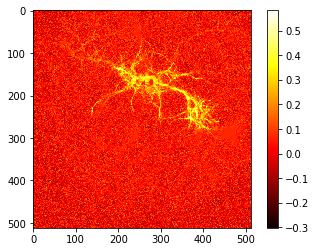

In [16]:
imshow(CorCoef_wave, cmap='hot')
colorbar()

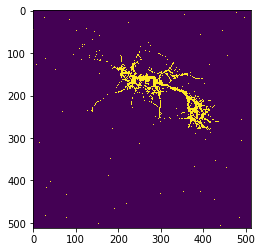

In [17]:
thld=mean(CorCoef_wave)+2.2*std(CorCoef_wave)
Mask_EMCCD=CorCoef_wave*1
Mask_EMCCD[Mask_EMCCD<thld]=0;
Mask_EMCCD[Mask_EMCCD>=thld]=1;
imshow(Mask_EMCCD);

In [18]:
#from matlab.make_mask import movavgy,movavgx

def movavgy (img, wind):
    sizeX, sizeY = img.shape
    imga=img*0
    wind2=wind//2
    for y in range(sizeY):
        for x in range(wind2,sizeX-wind2):
            imga[x,y]=nanmean(img[x-wind2:x+wind2+1,y])
    return imga
def movavgx (img, wind):
    return movavgy(img.transpose(), wind).transpose()


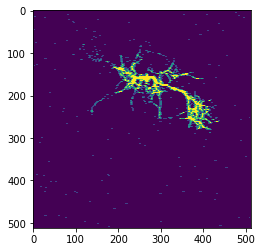

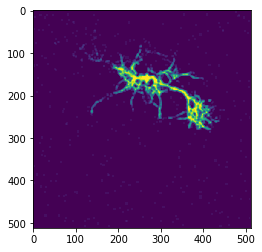

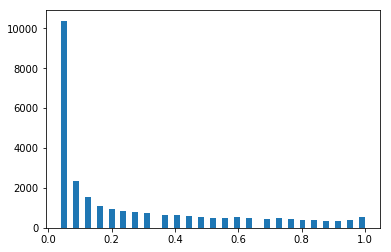

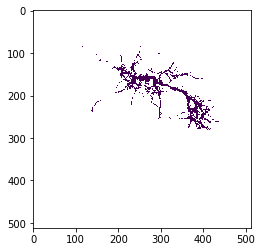

In [19]:
temp1=movavgx (Mask_EMCCD,5);
temp2=movavgy (temp1,5);
imshow(temp1)
figure()
imshow(temp2)
figure()
temp=temp2.flatten()
hist(temp[temp>0],51)
temp3=Mask_EMCCD*1;
temp3[temp2<=0.15]=nan;
temp3[temp3==0]=nan;
figure()
imshow(temp3)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


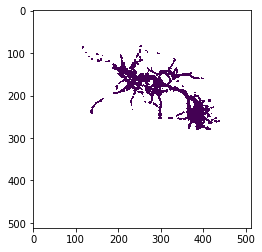

In [20]:
f=3
temp1=movavgx(temp3,f);
Mask_EMCCD_exp=movavgy (temp1,f);
imshow(Mask_EMCCD_exp)

(512, -10)

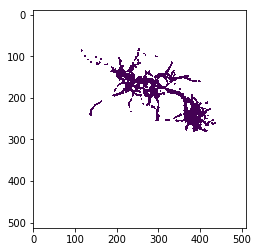

In [21]:
imshow(Mask_EMCCD_exp)
ylim(512,-10)

In [22]:
#import cv2

In [23]:
#from matlab.make_mask import calib

def calib(Mask, ax, ay, bx, by):
    Mask_CMOS=zeros(Mask.shape);
    for Xc in range(Mask_CMOS.shape[1]):
        for Yc in range(Mask_CMOS.shape[0]):
            Xe=int(ax*Xc+bx);
            Ye=int(ay*Yc+by);
            if Xe>-1 and Xe<Mask.shape[1] and Ye>-1 and Ye<Mask.shape[0]:
                Mask_CMOS[Yc,Xc]=Mask[Ye, Xe];
    Mask_CMOS[isnan(Mask_CMOS)]=0
    
    #kernel=2
    #kernelm = cv2.UMat(ones((kernel,kernel),float32)/float(kernel)**2)
    #dilated = cv2.dilate(Mask_CMOS,kernel=kernelm)
    return Mask_CMOS #array(dilated.get())


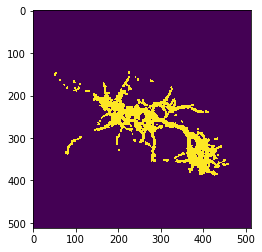

In [24]:
Mask_CMOS=calib(Mask_EMCCD_exp, ax, ay, bx, by)
imshow(Mask_CMOS)

##   Local maxima detection and ROI detection
### Local maxima detection
### Blinking coefficient and selection
### Neural-net?


In [25]:
from matlab.calib import extractpeaks2d0,afintransf, CMOS_2fields_calib

In [26]:
v = CMOS_2fields_calib(folder+foldercalib)

In [27]:
print(v)

[-5.0844909  -2.96550548]


In [28]:
calibim = readtifImage(folder+foldercalib+'calib_CMOS_2.tif')

In [29]:
ptsB = extractpeaks2d0(calibim[:,:512])

(<Figure size 504x324 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x216465c0c18>)

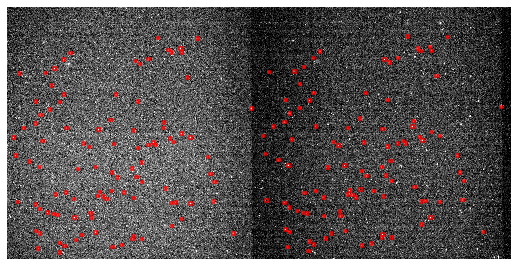

In [30]:
ptsR2 = 1.0*ptsB
ptsR2[:,0] += 512+v[0]
ptsR2[:,1] += v[1]
visualization(calibim,row_stack((ptsB[:100,:],ptsR2[:100,:])))

In [31]:
dx, dy = 512+v[0],v[1]

In [59]:
#folder = r"C:\Users\ludwig\data\NR sample files\18_11_29_pd23_11_div6_WIS_NR-BeRST\image files"
fname = fwave
movie = readBigTifFile(folder+fname)
movie_sum = movie.sum(axis=0) # sum(movie,axis=0)


In [60]:
info = readtifInfo(folder+fname)
NframesStr = [d for d in info[270].split('\n') if d.find('frames')>=0][0].split('=')[-1]
Nframes = int(NframesStr)

In [61]:
TacqStr = [d for d in info[270].split('\n') if d.find('finterval')>=0][0].split('=')[-1]
Tacq = float(TacqStr)


In [62]:
# Generating stimulation trace
Stim=tile([0, 0, -60, -60],Nframes//4);

(<Figure size 504x324 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2164b213d30>)

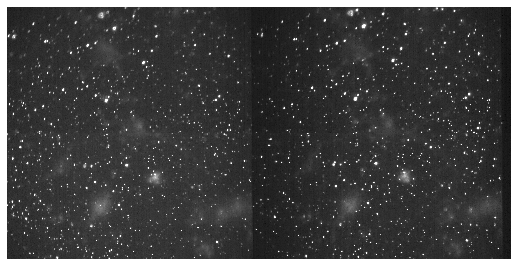

In [63]:
visualization(movie_sum)

In [64]:
kernel = 5
ROIsize=5
km = ones((kernel,kernel),float32)#/float(kernel)**2
J = zeros(Mask_CMOS.shape)
rs2 = kernel//2
mx,my = Mask_CMOS.shape

for x in range(0,mx-kernel):
    for y in range(0,my-kernel):
        temp = km*movie_sum[x:(x+kernel),y:(y+kernel)]
        J[x+rs2,y+rs2] = temp.max()

In [65]:
mx,my = Mask_CMOS.shape
pts = [] 
for x in range(2*ROIsize+1,mx-2*ROIsize):
    for y in range(2*ROIsize,my-2*ROIsize):
        if Mask_CMOS[x,y]>0 and J[x, y]==movie_sum[x, y]:
            pts.append([y, x])


pts = array(pts)

(<Figure size 1008x1008 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2164b251550>)

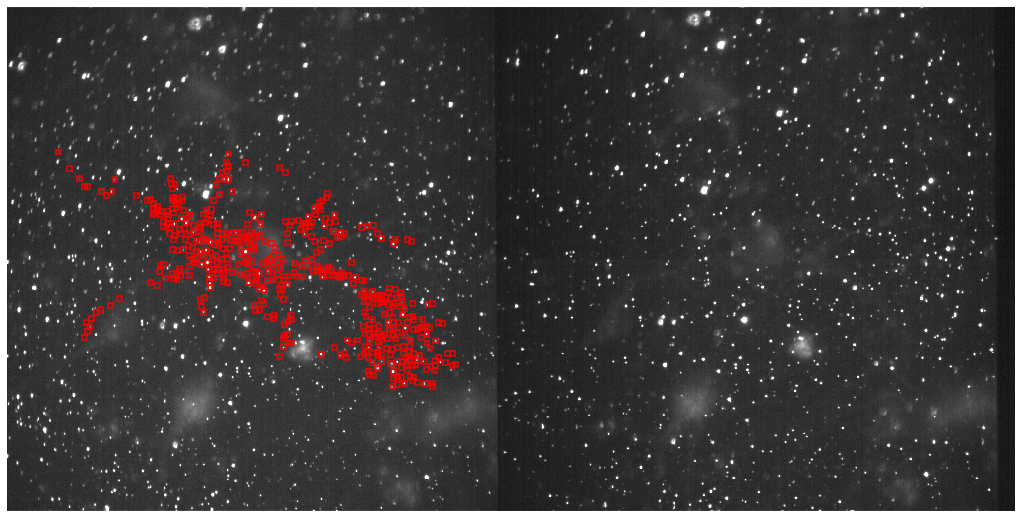

In [66]:
visualization(movie_sum,pts,figsize=(14,14))

In [67]:
x=pts[:,0]+dx
y=pts[:,1]+dy

In [68]:
sel = x+floor(ROIsize/2)<movie_sum.shape[1]
sel = sel*(y+floor(ROIsize/2)<movie_sum.shape[0])
sel = sel*(y-floor(ROIsize/2)>0)
x = x[sel]
y = y[sel]

(<Figure size 1008x1008 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x21649bbc240>)

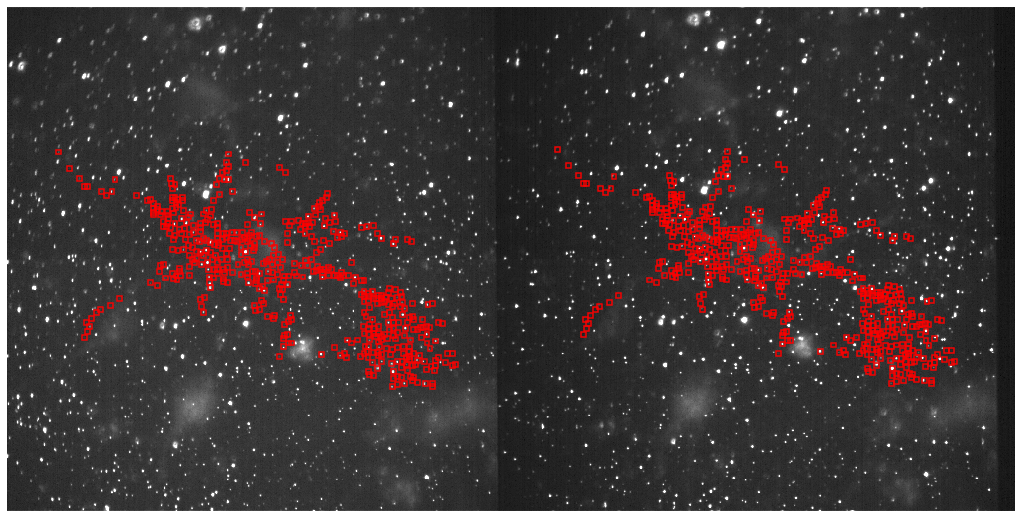

In [69]:
ptsr=column_stack((x,y))
ptsb=pts*1
pts_all=row_stack((ptsb,ptsr))
visualization(movie_sum,pts_all,figsize=(14,14))

##   Processing ROIs:
### Linearization of ROI
### Blinking substraction
### Stitching cycles
### Mobility



In [70]:
movie.shape

(6000, 512, 1024)

In [71]:
def MakeROIMovie(Movie,pts,ROIsize):

    NROI=shape(pts)[0]
    ROIs=zeros((2,ROIsize,NROI))
    ROIs_Movie=zeros((shape(Movie)[0],ROIsize,ROIsize,NROI))
    for i in range(NROI):
        # dimensions of ROIs_Movie: (X,Y,Frame,ROI#)
        # won't work for 1x1
        r2=(ROIsize-1)//2
        x0,xf = pts[i,0]-r2 , pts[i,0]+r2+1
        y0,yf = pts[i,1]-r2 , pts[i,1]+r2+1
        ROIs_Movie[:,:,:,i]=Movie[:, y0:yf , x0:xf]
    return ROIs_Movie

In [72]:
NROI=shape(pts_all)[0]

In [73]:
def extractLinearROIs(movie, pts_all, ROIsize):
    NROI=shape(pts_all)[0]
    Nframes, sizeY, sizeX = movie.shape
    ROIs_Movie = MakeROIMovie(movie,array(pts_all,dtype=int),ROIsize)
    # we reshape it to have ROIS as linear vectors
    Linear_ROIs_Movie=reshape(ROIs_Movie,(Nframes, ROIsize**2,NROI))
    
    # Sort pxs each frame
    Linear_ROIs_Movie.sort(axis=1)
    # We decide the background and the signal
    Linear_ROIs_Movie_Back=Linear_ROIs_Movie[:,0:ROIsize,:]
    Linear_ROIs_Movie_Signal=Linear_ROIs_Movie[:,ROIsize:,:]
    
    # Final signal and sum of the 2 channels
    Signal=sum(Linear_ROIs_Movie_Signal-mean(Linear_ROIs_Movie_Back, axis=1, keepdims=True), axis=1)/Tacq   
    Signal_2ch=Signal[:,0:NROI//2]+Signal[:,NROI//2:]
    
    return(Signal, Signal_2ch)

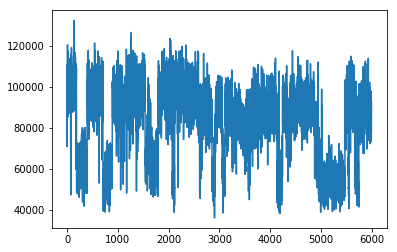

In [74]:
Signal, Signal_2ch = extractLinearROIs(movie,pts_all, ROIsize)
temp = randint(Signal_2ch.shape[1])

plot(Signal_2ch[:,temp])


In [75]:
def classifier0(Signal_2ch, threshold = 0.45):
    temp1=mean(Signal_2ch, axis=0)
    temp2=mean((Signal_2ch-temp1)**2, axis=0)
    temp3=mean((Signal_2ch-temp1)**3, axis=0)/temp2**(3.0/2.0)
    temp4=mean((Signal_2ch-temp1)**4, axis=0)/temp2**(4.0/2.0)
    classifier=(temp3**2+1)/temp4

    idx = (-classifier).argsort()
    # selecting ROIs

    ROI_selected=arange(len(classifier))[classifier>threshold]

    if sum(ROI_selected)==0:
        print('no ROI selected')
    return(classifier, ROI_selected)

In [76]:
classifier, ROI_selected = classifier0(Signal_2ch, threshold = 0.45)

168 : 0.33921652013118375
[  1  14  23  49  67  73  87  89  97 103 104 113 146 153 159 165 180 184
 215 228 251 265 287 291 295 302 328 335 342 385 413 419 421 422 443 454
 459 462 463 486 487 490]


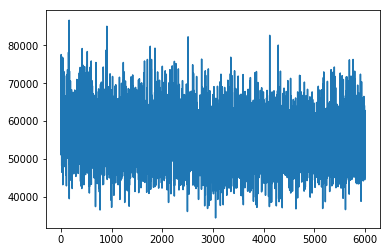

In [77]:
temp = randint(Signal_2ch.shape[1])
#temp = 1
plot(Signal_2ch[:,temp])
print(temp,':',classifier[temp])
print(ROI_selected)

In [78]:
def getSignalsep(Signal,ROI_selected,NROI = Signal.shape[0]//2):
    Signalsep=Signal[:,ROI_selected]
    Signalsep=column_stack((Signalsep, Signal[:,NROI//2+ROI_selected])) 
    return(Signalsep)


In [79]:
Signal_wave = getSignalsep(Signal,ROI_selected,NROI = NROI)

pts_blue=pts_all[ROI_selected,:]
pts_red=pts_all[ROI_selected+NROI//2,:]
pts=row_stack((pts_blue, pts_red))


In [80]:
# Same for the control
fname = fctrl
movie = readBigTifFile(folder+fname)
# Do we use same points: or we get new ones?
Signalct, Signal_2ch_ctrl = extractLinearROIs(movie,pts_all, ROIsize)
classifierct, ROI_selectedct = classifier0(Signal_2ch_ctrl, threshold = 0.45)



In [81]:
print(ROI_selectedct, ROI_selected)

[  1  13  14  23  24  49  67  71  73  81 103 113 114 141 146 153 159 165
 180 228 251 265 269 285 291 295 302 335 342 353 397 413 419 421 462 471
 486 490] [  1  14  23  49  67  73  87  89  97 103 104 113 146 153 159 165 180 184
 215 228 251 265 287 291 295 302 328 335 342 385 413 419 421 422 443 454
 459 462 463 486 487 490]


In [84]:
ROI_sel=[]
for i in ROI_selected:
    if i in ROI_selectedct:
        ROI_sel.append(i)
print(ROI_sel)
ROI_sel=array(ROI_sel)

[1, 14, 23, 49, 67, 73, 103, 113, 146, 153, 159, 165, 180, 228, 251, 265, 291, 295, 302, 335, 342, 413, 419, 421, 462, 486, 490]


In [97]:
Signal_wave = getSignalsep(Signal,ROI_sel,NROI = NROI)
Signal_ctrl = getSignalsep(Signalct,ROI_sel,NROI = NROI)
NROI=shape(Signal_wave)[1]//2
Signal_2ch_wave = Signal_wave[:,0:NROI] + Signal_wave[:,NROI:]
Signal_2ch_ctrl = Signal_ctrl[:,0:NROI] + Signal_ctrl[:,NROI:]

(6000, 27)

In [88]:
#print(ROI_selected)
#print(NROI//2+ROI_selected)
shape(ROI_sel)
#print(NROI)

(27,)

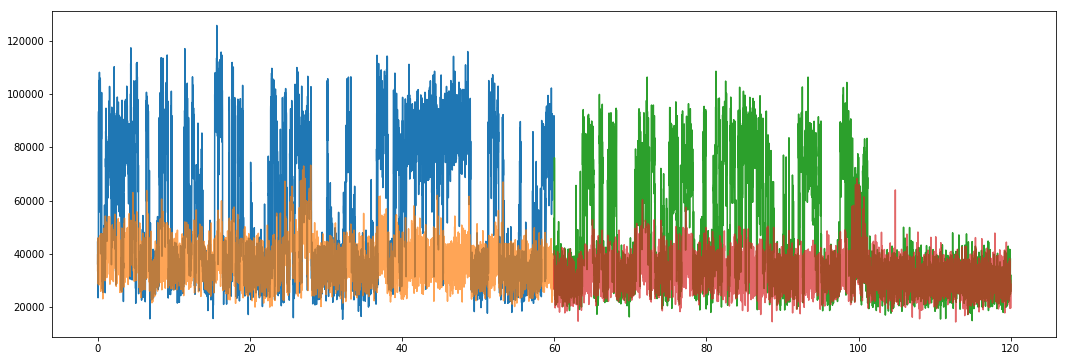

In [93]:
temp=randint(27)
figure(figsize=(18,6))
plot(arange(6000)*0.01,Signal_wave[:,temp])
plot(arange(6000)*0.01,Signal_wave[:,temp+27], alpha=.7)

plot(arange(6000)*0.01+60,Signal_ctrl[:,temp])
plot(arange(6000)*0.01+60,Signal_ctrl[:,temp+27], alpha=.7)

In [94]:
from scipy.optimize import minimize

def gaussd(x,par): return(exp(-(x-par[0])**2/2/par[1]**2)/sqrt(2*pi*par[1]**2) )
def dblgaussd(x,par): return(par[0]**2*gaussd(x,par[1:3])+(1.0-par[0]**2)*gaussd(x,par[3:]))

def dblgausfit(x,y,wy=1.0,par0=array([sqrt(0.5),-1,.5,1,.5])):
    def minf(par): return( sum(wy*(dblgaussd(x,par)-y)**2)/sum(wy))
    minx  = minimize(minf,par0)
    return minx

In [112]:
def get_treshold(Signal, NROI):
    threshold=zeros(NROI)
    for j in range(NROI):
        A, edges=histogram(Signal[:,j],40, density=True)
        xData, yData = edges[0:-1], A
        sig_mean=mean(Signal[:,j]);
        sig_std=std(Signal[:,j]);
        seed=array([1/2, sig_mean-sig_std, sig_std/2, sig_mean+sig_std, sig_std/2]);

        fitresult = dblgausfit(xData, yData, par0=seed);
        _, lm, ls, hm, hs=fitresult.x;
        if lm>hm:
            tm, ts = lm, ls
            lm, ls = hm, hs
            hm, hs = tm, ts
        if lm+ls*2<hm:
            threshold[j]=lm+ls*2
        else:
            threshold[j]=mean(lm, hm);
    return threshold

In [115]:

threshold_2ch_wave=get_treshold(Signal_2ch_wave, NROI)
threshold_2ch_ctrl=get_treshold(Signal_2ch_ctrl, NROI)



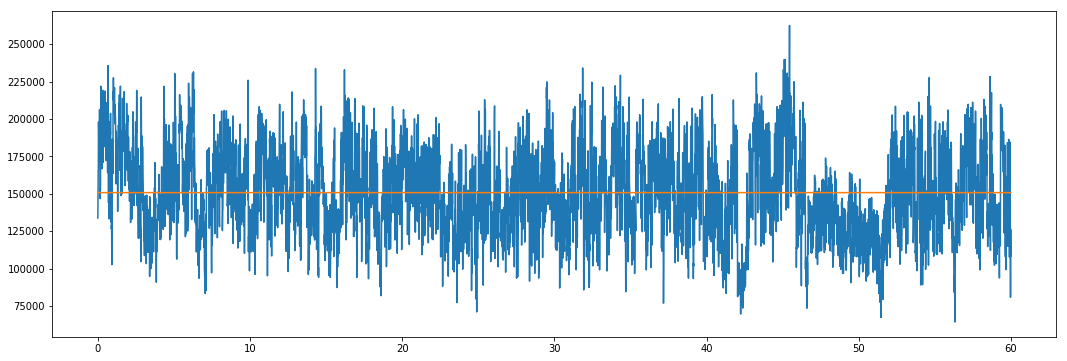

In [132]:
temp=randint(27)
figure(figsize=(18,6))
plot(arange(6000)*0.01,Signal_2ch_wave[:,temp])
plot(arange(6000)*0.01, arange(6000)*0+threshold_2ch_wave[temp])


In [120]:
OnState_wave=Signal_2ch_wave<=threshold_2ch_wave
print(OnState_wave.sum(axis=0))

[3206 2614 2744 2945 2779 3048 2323 2699 3083 2919 2797 2805 2765 2581
 3034 3213 2746 2869 3080 3195 3244 3165 2986 2743 2787 2448 3507]


In [123]:
print(sum(Signal_2ch_wave[:,1]<threshold_2ch_wave[1]))

2614


In [125]:
OnState_wave=Signal_2ch_wave<=threshold_2ch_wave
Signal_2ch_OnState_wave=Signal_2ch_wave*1
Signal_2ch_OnState_wave[OnState_wave]=nan;

OnState_wave_2=column_stack((OnState_wave,OnState_wave))

Signal_OnState_wave=Signal_wave*1;
Signal_OnState_wave[OnState_wave_2]=nan;

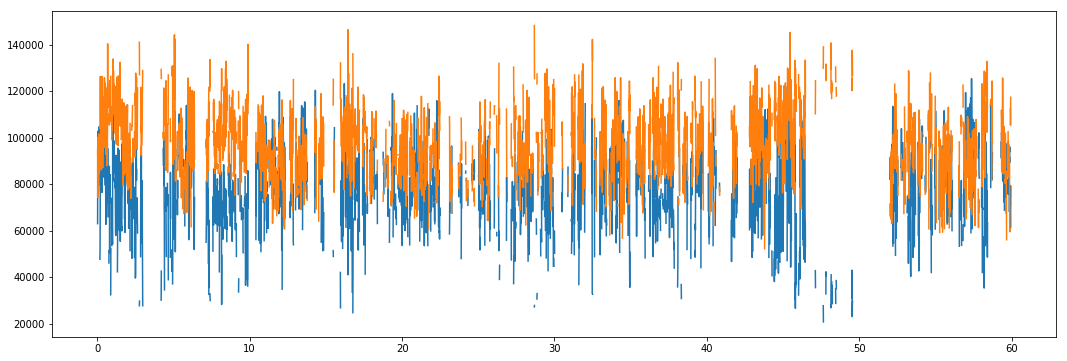

In [133]:
figure(figsize=(18,6))
plot(arange(6000)*0.01,Signal_OnState_wave[:,temp])
plot(arange(6000)*0.01,Signal_OnState_wave[:,temp+27])

In [137]:
OnState_ctrl=Signal_2ch_ctrl<=threshold_2ch_ctrl
Signal_2ch_OnState_ctrl=Signal_2ch_ctrl*1
Signal_2ch_OnState_ctrl[OnState_ctrl]=nan;

OnState_ctrl_2=column_stack((OnState_wave,OnState_ctrl))

Signal_OnState_ctrl=Signal_ctrl*1;
Signal_OnState_ctrl[OnState_ctrl_2]=nan;

In [139]:
Ratio_wave=zeros((Nframes,NROI))
Ratio_wave=Signal_OnState_wave[:,0:NROI]/Signal_2ch_OnState_wave
Ratio_ctrl=zeros((Nframes,NROI))
Ratio_ctrl=Signal_OnState_ctrl[:,0:NROI]/Signal_2ch_OnState_ctrl

##    Extracting Signal
### FT score calculation
### Interval extraction



##   Bootstrap?

